# Thresholding group analyses

This part of the tutorial mainly covered methods that used widely:
* Family-wise error rate (Bonferreoni correction, Random Field Theory based cluster correction)
* False discovery rate
* Non-parametric approach

The whole thresholding is to balance between type I and type II error, so I will skip the theoretical part and only focus on the code.

## Simulations

First, use simulation to grasp the type I and type II error.

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data
from nltools.simulator import SimulateGrid

/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


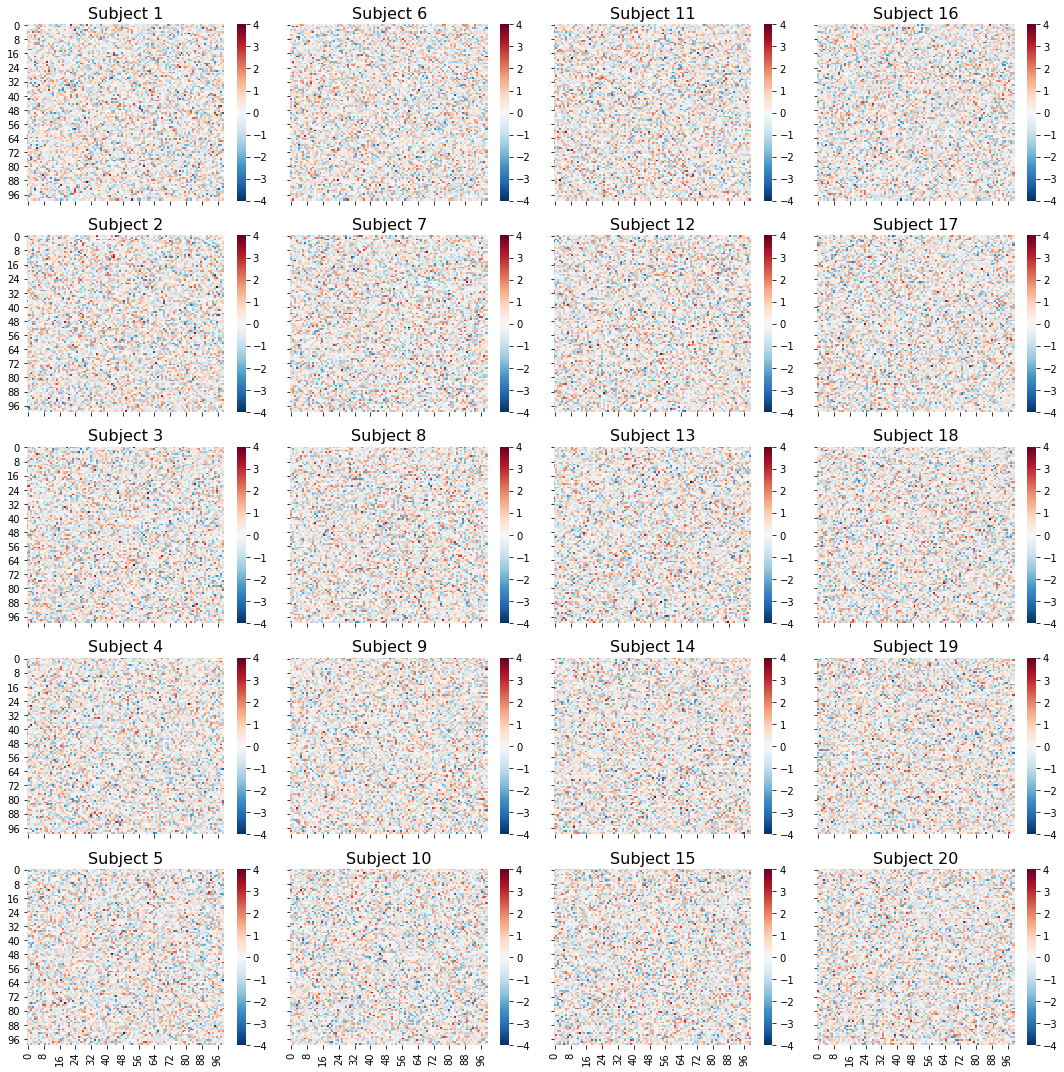

In [3]:
simulation = SimulateGrid(grid_width=100, n_subjects=20)

f, a = plt.subplots(nrows=5, ncols=4, figsize=(15,15), sharex=True, sharey=True)
counter = 0
for col in range(4):
    for row in range(5):
        sns.heatmap(simulation.data[:, :, counter], ax=a[row, col], cmap='RdBu_r', vmin=-4, vmax=4)
        a[row, col].set_title(f'Subject {counter+1}', fontsize=16)
        counter+=1
plt.tight_layout()
    

The above plot simply represents 20 independent subjects.

We can then start to running simulations to get a sense of the number of the type I error.

Text(0.5, 1.0, 'T Values')

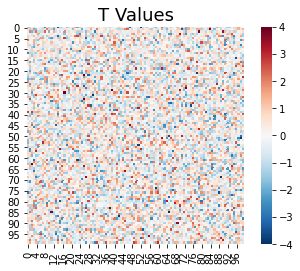

In [4]:
simulation.fit()

sns.heatmap(simulation.t_values, square=True, cmap='RdBu_r', vmin=-4, vmax=4)
plt.title("T Values", fontsize=18)

The above plot clear shows that, even without meaning signal, there are a number of pixels in the grid exceed above 2 or -2, which is the approximate cutoff for p < 0.05.

Let's now apply a threshold and see how the false positive rate will be. To calculate the false positive, we simply count the number of test that exceed this threshold.

If we run this simulation again 100 times, we can estimate the false positive rate, which is the average number of false positives over all 100 simulations.

Let's see what this looks like for a threshold of $p< 0.05$

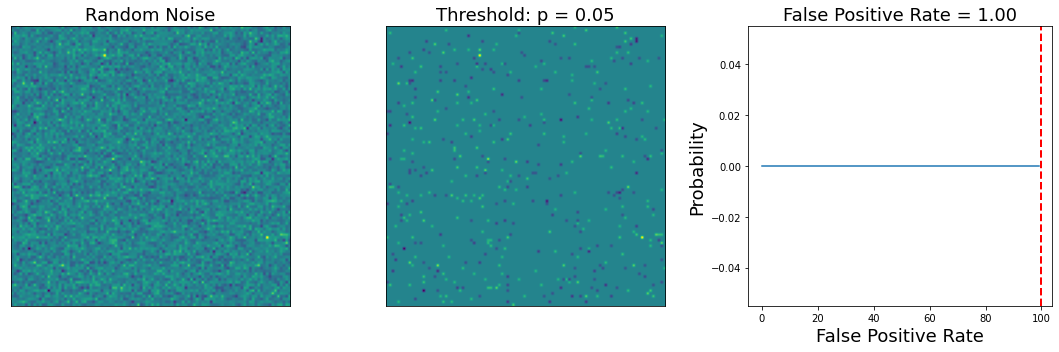

In [5]:
threshold = .05
simulation = SimulateGrid(grid_width=100, n_subjects=20)
simulation.plot_grid_simulation(threshold=threshold, threshold_type='p', n_simulations=100)

The left panel: the averaged image of all subjects.

The middle panel: voxels that exceed the statistical threshold;

The right panel: overall false-positive rate across the 100 simulation. This shows that a threshold of p < 0.05 results in observing at least one voxels that is a false positive across every one of our 100 simulations.

What if we looked at fewer number of voxels?

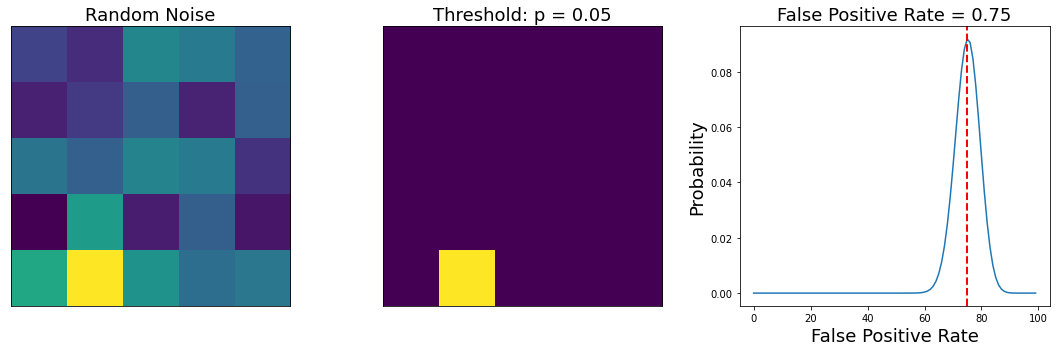

In [6]:
threshold = .05
simulation = SimulateGrid(grid_width=5, n_subjects=20)
simulation.plot_grid_simulation(threshold=threshold, threshold_type='p', n_simulations=100)

This simulation shows that examining fewer numbers of voxels will yield considerably less false positives. This is an approach to controlling for mutiple test involves only looking for voxels within a specific region of interest.


Another approach: increase the threshold on our original 100 * 100 grid

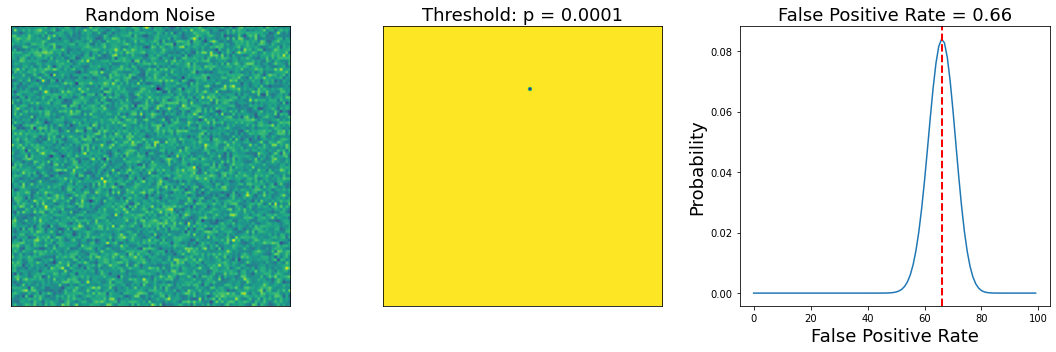

In [7]:
threshold = .0001
simulation = SimulateGrid(grid_width=100, n_subjects=20)
simulation.plot_grid_simulation(threshold=threshold, threshold_type='p', n_simulations=100)

As we can see, stringent threshold dramatically decrease the number of false positive.

But what is the optimal threshold that will give us an $\alpha = 0.05$?

To calculate this, we will run 100 simulation at different threshold levels to find the threshold that leads to a false positive rate that is lower than our alpha value.

We could search over t-value or p-value, let's explore t-value first.

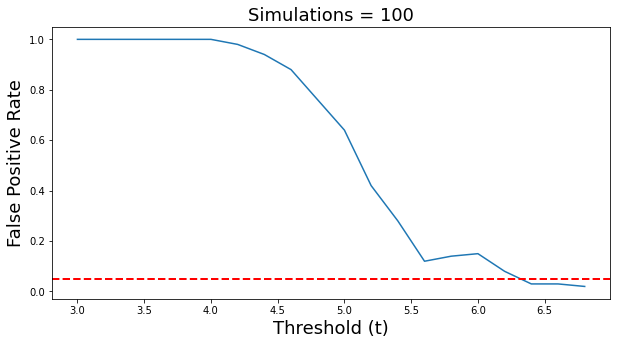

In [8]:
alpha = 0.05
n_simulations = 100
x = np.arange(3, 7, .2)

sim_all = []

for p in x:
    sim = SimulateGrid(grid_width=100, n_subjects=20)
    sim.run_multiple_simulations(threshold=p, threshold_type='t', n_simulations=n_simulations)
    sim_all.append(sim.fpr)
    
f, a = plt.subplots(ncols=1, figsize=(10,5))
a.plot(x, np.array(sim_all))
a.set_ylabel('False Positive Rate', fontsize=18)
a.set_xlabel('Threshold (t)', fontsize=18)
a.set_title(f'Simulations = {n_simulations}', fontsize=18)
a.axhline(y=alpha, color='r', linestyle='dashed', linewidth=2)

Here we can see that the false positive rate is close to our alpha starting at a threshold of about 6.3. This means that when test a hypothesis over 10,000 indepdent voxels, we can be confident that we will only observe false positive in approximately 5 out of 100 exmperiments. This means we effectively control the family wise error rate (FWER).

Let's use this threshold for our simulation again.

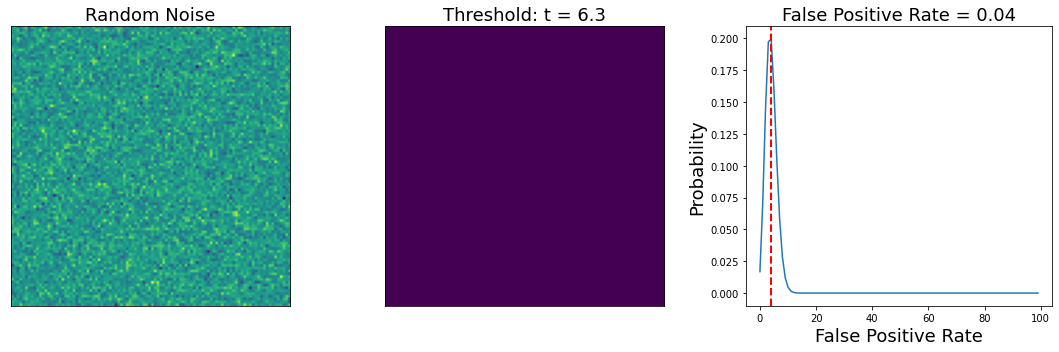

In [9]:
simulation = SimulateGrid(grid_width=100, n_subjects=20)
simulation.plot_grid_simulation(threshold=6.3, threshold_type='t', n_simulations=100)

Another way to control FWER is Bonferroni correction

$ Bonferroni = \frac {a}{M}$, where $M$ is the number of tests (voxels)

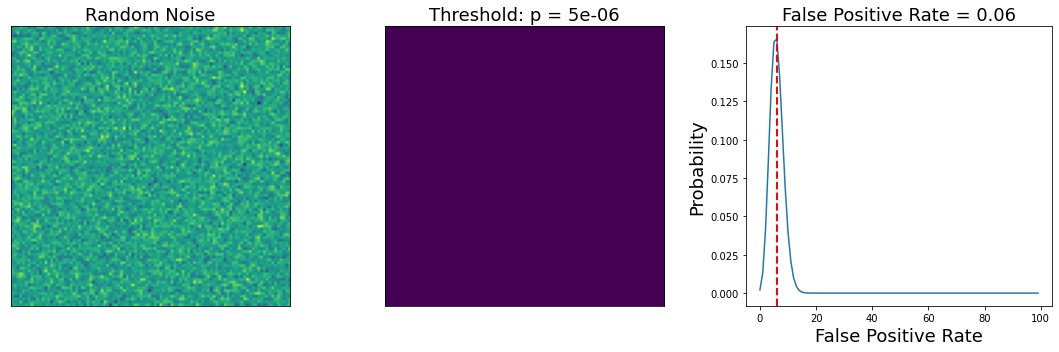

In [10]:
grid_width = 100
threshold = 0.05/(grid_width**2)
simulation = SimulateGrid(grid_width=grid_width, n_subjects=20)
simulation.plot_grid_simulation(threshold=threshold, threshold_type='p', n_simulations=100)

Seems that we minimized our false positive

How about the false negative? 

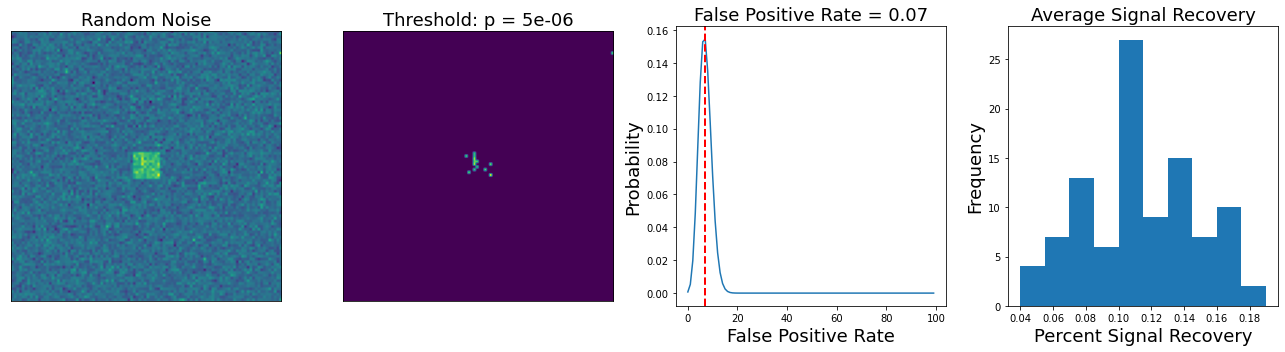

In [12]:
grid_width = 100
threshold = .05/(grid_width**2)
signal_width = 10
signal_amplitude = 1

simulation = SimulateGrid(signal_amplitude=signal_amplitude, 
                          signal_width = signal_width,
                          grid_width=grid_width, 
                          n_subjects=20)
simulation.plot_grid_simulation(threshold=threshold, threshold_type='p', n_simulations=100)

The fourth panel shows the average signal recovery (how many voxels within the true signal square survided across all 100 simulations)

This simulation shows that with Bonferroni, we control the false positive, but the power ($1- false \ negative$) is low.

### Cluster extent

...

## To real data

Let's exploring two simple and fast ways to threshold previous group analysis

First, we will simply threshold based on selecting an arbitrary statistical threshold. Let's call it *uncorrected*

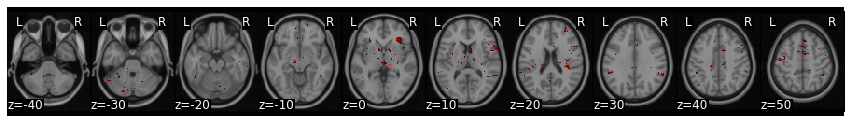

In [16]:
data_dir = '/home/hcp4715/Data/RepDopa/Nipy/BIDS'

cond1_name = 'CSpl'
# folder strucutre: session
cond1_file_list = glob.glob(os.path.join(data_dir, 'derivatives', 'fmriprep', '*', '*', 'func', f'sub*_ses*_{cond1_name}*nii.gz'))
cond1_file_list.sort()
#cond1_file_list
cond1_dat = Brain_Data(cond1_file_list)
cond1_stats = cond1_dat.ttest(threshold_dict={'unc':.001})

cond1_stats['thr_t'].plot()

Let's run FDR correction

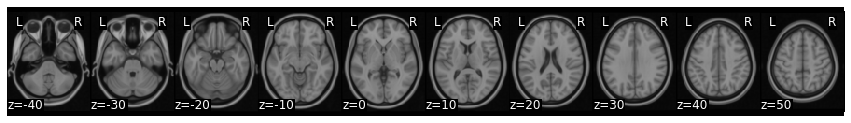

In [17]:
cond1_stats = cond1_dat.ttest(threshold_dict={'fdr':.05})
cond1_stats['thr_t'].plot()

We can see that FDR is more conservative than uncorrected.

Let's look at another contrast between CS+ and CS-

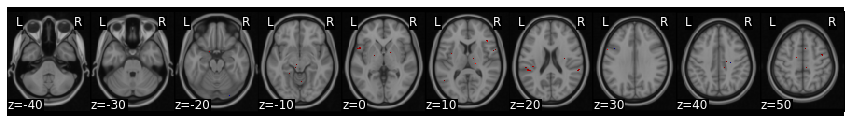

In [20]:
cond2_name = 'CSmin'
cond2_file_list = glob.glob(os.path.join(data_dir, 'derivatives', 'fmriprep', '*', '*', 'func', f'sub*_ses*_{cond2_name}*nii.gz'))
cond2_file_list.sort()
cond2_dat = Brain_Data(cond2_file_list)

cond1_v_cond2 = cond1_dat - cond2_dat
cond1_v_cond2_stats = cond1_v_cond2.ttest(threshold_dict={'unc':0.001})
cond1_v_cond2_stats['thr_t'].plot()

/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


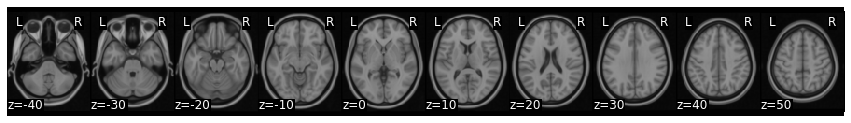

In [22]:
cond1_v_cond2_stats = cond1_v_cond2.ttest(threshold_dict={'fdr':0.05})
cond1_v_cond2_stats['thr_t'].plot()